In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

In [2]:
%matplotlib inline
torch.manual_seed(1)

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize((0, 0, 0),(1, 1, 1))]
                                                        ))

In [4]:
def weight_init(layer):
    if type(m) in [nn.Conv2d, nn.Linear]:
        layer.data = nn.init.xavier_normal(layer.data.size())
        if layer.bias:
            layer.bias.data = nn.init.zeros_(layer.bias.size())

In [5]:
len(train_dataset)

60000

tensor(5)


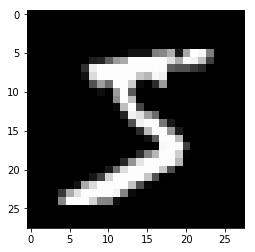

In [6]:
plt.imshow(train_dataset.train_data[0].numpy(), cmap='gray')
print(train_dataset.train_labels[0])

In [7]:
batch_size = 128
iterations = 3000
n_epochs = iterations/(len(train_dataset)/batch_size)
n_epochs = int(n_epochs)

In [8]:
train_loader = data.DataLoader(train_dataset, batch_size, shuffle=True)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def fully_connected(input_dim, output_dim, dropout=True, keep_prob=0.7, batch_norm=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_dim))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(1-keep_prob))
            return layers
        
        self.model_seg1 = nn.Sequential(
            # input shape: (28, 28, 1), output shape: (28, 28, 16)
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # input shape: (28, 28, 16), output shape: (14, 14, 16)
            nn.MaxPool2d(2),
            
            # input shape: (14, 14, 16), output shape: (14, 14, 32)
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # input shape: (14, 14, 32), output shape: (7, 7, 32)
            nn.MaxPool2d(2))
        
        self.model_seg2 = nn.Sequential(   
            # flatten input for FC
            *fully_connected(7*7*32, 100),
            *fully_connected(100, 50),
             
            # read out
            nn.Linear(50, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        # model segment 1
        out = self.model_seg1(x)
        
        # flatten
        out = out.view(x.size(0), -1)
        
        # model segment 2
        out = self.model_seg2(out)
        
        return out

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model_seg1 = nn.Sequential(
            # input shape: (112, 112, 1), output shape: (112, 112, 2)
            nn.Conv2d(1, 2, 5, 1, 2),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            
            # input shape: (112, 112, 2), output shape: (56, 56, 2)
            nn.MaxPool2d(2),
            
            # input shape: (56, 56, 2), output shape: (56, 56, 4)
            nn.Conv2d(2, 4, 5, 1, 2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            
            # input shape: (56, 56, 4), output shape: (28, 28, 4)
            nn.MaxPool2d(2),
            
            # input shape: (28, 28, 4), output shape: (28, 28, 16)
            nn.Conv2d(4, 16, 5, 1, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # input shape: (28, 28, 16), output shape: (14, 14, 16)
            nn.MaxPool2d(2))
        
        self.model_seg2 = nn.Sequential(
            nn.Linear(14*14*16, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            
            nn.Linear(1000, 28*28),
            nn.Tanh())
    
    def forward(self, z):
        z = self.model_seg1(z)
        # flatten for FC
        z = z.view(z.size(0), -1)
        z = self.model_seg2(z)
        # reshape to image size
        z = z.view(z.size(0), 1, 28, 28)
        return z

In [17]:
generator = Generator()
discriminator = Discriminator()

In [18]:
adversarial_criterion = nn.BCELoss()

In [19]:
optimizer_dis = torch.optim.SGD(discriminator.parameters(), lr=0.01)
optimizer_gen = torch.optim.SGD(generator.parameters(), lr=0.01)

In [20]:
Tensor = torch.FloatTensor

In [21]:
counter=0
gen_loss = []
dis_loss = []
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        valid = Variable(Tensor(images.size(0), 1).fill_(1.0))
        fake = Variable(Tensor(images.size(0), 1).fill_(0.0))
        
        real_images = Variable(images.type(Tensor))
        z = np.random.normal(2, 1, (images.size(0), 1, 112, 112))
        z = Variable(Tensor(z))
        gen_images = generator(z)
        
        
        # Generator training
        optimizer_gen.zero_grad()
        generator_loss = adversarial_criterion(discriminator(gen_images), valid)
        gen_loss.append(generator_loss.data)
        generator_loss.backward()
        optimizer_gen.step()
        
        # Discriminator training
        optimizer_dis.zero_grad()
        real_images_loss = adversarial_criterion(discriminator(real_images), valid)
        gen_images_loss = adversarial_criterion(discriminator(gen_images.detach()), fake)
        discriminator_loss = (real_images_loss + gen_images_loss)/2
        dis_loss.append(discriminator_loss.data)
        discriminator_loss.backward()
        optimizer_dis.step()
        
        if counter%500 == 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, 
                                                                              len(train_loader),
                                                            discriminator_loss.data, generator_loss.data))
            save_image(gen_images.data[:25],'images/gan_iter_%d.png'%counter, normalize=True, nrow=5)
        counter += 1

[Epoch 0/6] [Batch 0/469] [D loss: 0.701110] [G loss: 0.701417]
[Epoch 1/6] [Batch 31/469] [D loss: 0.695864] [G loss: 0.707462]
[Epoch 2/6] [Batch 62/469] [D loss: 0.690740] [G loss: 0.708189]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax0 =  fig.add_subplot(111)
ax0.plot(gen_loss, c='red')
ax0.plot(dis_loss, c='orange')
plt.show()

In [ ]:
def generate_noise(num=5):
    z = np.random.normal(2, 1, (num, 1, 112, 112))
    z = Variable(Tensor(z))
    return z

In [ ]:
z = generate_noise()
img = generator(z)
img = img.detach().numpy().squeeze()

In [ ]:
plt.imshow(img[2], cmap='gray')